In [1]:
%pip install ollama paddleocr opencv-python numpy pandas matplotlib seaborn

import os
import cv2
import matplotlib.pyplot as plt
import time
import glob
import numpy as np
import pandas as pd
import subprocess
from paddleocr import PaddleOCR

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'g:\dosen\tutoring-flow\venv1\Scripts\python.exe -m pip install --upgrade pip' command.
g:\dosen\tutoring-flow\venv1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Checking connectivity to the model hosters, this may take a while. To bypass this check, set `PADDLE_PDX_DISABLE_MODEL_SOURCE_CHECK` to `True`.


In [2]:
DATASET_DIR = r'G:\dosen\dataset\SOAL3'
IMAGES_DIR = DATASET_DIR
GT_DIR = DATASET_DIR

# ===================== LIMIT PROCESSING =====================
USE_LIMIT = True  # Set to True to limit the number of processed files
LIMIT_COUNT = 10   # Number of files to process if limit is active

In [3]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def calculate_cer(reference, hypothesis):
    if not reference:
        return 0.0
    ref = " ".join(reference.split())
    hyp = " ".join(hypothesis.split())
    return levenshtein_distance(ref, hyp) / len(ref)

In [4]:
def read_ground_truth(filename_base):
    path = os.path.join(GT_DIR, f"{filename_base}.txt")
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            return f.read().strip()
    return ""

In [5]:
print("Initializing PaddleOCR...")
ocr = PaddleOCR(lang="en", enable_mkldnn=False, use_angle_cls=True)

Initializing PaddleOCR...


C:\Users\sudes\AppData\Local\Temp\ipykernel_13716\2190322544.py:2: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(lang="en", enable_mkldnn=False, use_angle_cls=True)
g:\dosen\tutoring-flow\venv1\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:712: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\sudes\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\sudes\.paddlex\official_mo

In [6]:
def run_llm(prompt):
    # Run subprocess with robust encoding handling
    try:
        result = subprocess.run(
            ["ollama", "run", "qwen3"],
            input=prompt,
            text=True,
            capture_output=True,
            encoding='utf-8',       # Ensure UTF-8 for I/O
            errors='replace'        # Replace chars that fail to encode/decode (fixes charmap error)
        )
        if result.returncode != 0:
            print(f"  [LLM ERROR] Exit Code: {result.returncode}")
            print(f"  [LLM STDERR] {result.stderr[:200]}...") # Print part of stderr
            return None
            
        return result.stdout.strip()
    except Exception as e:
        print(f"  [LLM EXCEPTION] {e}")
        return None

In [7]:
image_files = (
    glob.glob(os.path.join(IMAGES_DIR, "*.jpg")) +
    glob.glob(os.path.join(IMAGES_DIR, "*.png")) +
    glob.glob(os.path.join(IMAGES_DIR, "*.jpeg"))
)


results = []

# Apply Limit if Enabled
if USE_LIMIT and LIMIT_COUNT > 0:
    print(f"Limiting processing to first {LIMIT_COUNT} images.")
    image_files = image_files[:LIMIT_COUNT]

print(f"Found {len(image_files)} images.")

Limiting processing to first 10 images.
Found 10 images.


In [8]:
for idx, image_path in enumerate(image_files):
    filename = os.path.basename(image_path)
    filename_base = os.path.splitext(filename)[0]
    gt_text = read_ground_truth(filename_base)

    print(f"\nProcessing [{idx+1}/{len(image_files)}]: {filename}...")
    start_time = time.time()

    # ---------- OCR ----------
    ocr_result = ocr.predict(image_path)
    extracted_lines = []
    bboxes = []

    if ocr_result and len(ocr_result) > 0:
        if isinstance(ocr_result[0], dict) and "rec_texts" in ocr_result[0]:
            extracted_lines = ocr_result[0]["rec_texts"]
            if "dt_polys" in ocr_result[0]:
                bboxes = ocr_result[0]["dt_polys"]
        elif isinstance(ocr_result[0], list):
            for line in ocr_result[0]:
                if isinstance(line, list) and len(line) >= 2:
                    if isinstance(line[1], (tuple, list)):
                        extracted_lines.append(line[1][0])
                    if isinstance(line[0], list):
                        bboxes.append(line[0])

    raw_text = "\n".join(extracted_lines)

    # ---------- VISUALIZATION & BBOX ----------
    if bboxes:
        img_vis = cv2.imread(image_path)
        if img_vis is not None:
            img_vis = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
            for box in bboxes:
                box = np.array(box).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(img_vis, [box], True, (255, 0, 0), 2)
            
            # Save Image
            os.makedirs(r'results/bbox', exist_ok=True)
            vis_path = os.path.join(r'results/bbox', f'vis_{filename}')
            plt.figure(figsize=(10, 10))
            plt.imshow(img_vis)
            plt.axis('off')
            plt.savefig(vis_path, bbox_inches='tight')
            plt.close()
            
            # Save Coords TXT
            txt_path = os.path.join(r'results/bbox', f'bbox_{filename_base}.txt')
            with open(txt_path, 'w', encoding='utf-8') as f:
                for i, box in enumerate(bboxes):
                    text = extracted_lines[i] if i < len(extracted_lines) else ''
                    f.write(f'{box} | {text}\n')

    # ---------- LLM ----------
    final_text = raw_text

    if raw_text.strip():
        if not os.path.exists("prompting.txt"):
            print("  [ERROR] prompting.txt not found!")
            continue
        with open("prompting.txt", "r", encoding="utf-8") as f:
            prompt = f.read().replace("{OCR_TEXT}", raw_text)

        print("  [LLM] running...")
        llm_out = run_llm(prompt)

        if llm_out is None:
            print("  [LLM] timeout → skip")
            final_text = raw_text
        else:
            final_text = (
                llm_out
                .replace("```plaintext", "")
                .replace("```", "")
                .strip()
            )
            print("  [LLM] done")

    # ---------- METRIC ----------
    elapsed = time.time() - start_time
    cer_raw = calculate_cer(gt_text, raw_text)
    cer_refined = calculate_cer(gt_text, final_text)

    print(
        f"  OCR Length: {len(raw_text)} | "
        f"CER Raw: {cer_raw:.2%} | "
        f"CER Refined: {cer_refined:.2%} | "
        f"Time: {elapsed:.2f}s"
    )

    results.append({
        "filename": filename,
        "time": elapsed,
        "cer_raw": cer_raw,
        "cer_refined": cer_refined,
        "raw_text": raw_text,
        "final_text": final_text,
        "ground_truth": gt_text
    })

    # Save partial results incrementally
    if len(results) > 0:
        pd.DataFrame(results).to_csv('results/Tes2_results.csv', index=False)

print("\nDONE. Total processed:", len(results))


Processing [1/10]: if4908_103012400180_nomor3.jpg...
  [LLM] running...
  [LLM] done
  OCR Length: 367 | CER Raw: 50.00% | CER Refined: 1159.62% | Time: 192.14s

Processing [2/10]: if4908_103012400221_nomor3.jpg...
  [LLM] running...
  [LLM] done
  OCR Length: 184 | CER Raw: 29.27% | CER Refined: 3392.20% | Time: 289.27s

Processing [3/10]: if4908_103012400283_nomor3.jpg...
  [LLM] running...
  [LLM] done
  OCR Length: 100 | CER Raw: 0.00% | CER Refined: 0.00% | Time: 125.58s

Processing [4/10]: if4908_103012400355_nomor3.jpg...
  [LLM] running...
  [LLM] done
  OCR Length: 200 | CER Raw: 32.71% | CER Refined: 1716.36% | Time: 198.91s

Processing [5/10]: if4908_103012400374_nomor3.jpg...
  [LLM] running...
  [LLM] done
  OCR Length: 255 | CER Raw: 37.18% | CER Refined: 2324.36% | Time: 322.88s

Processing [6/10]: if4908_103012500007_nomor3.jpg...
  [LLM] running...
  [LLM] done
  OCR Length: 252 | CER Raw: 40.50% | CER Refined: 1653.27% | Time: 487.32s

Processing [7/10]: if4908_10301

Average Time: 288.6853s
Average CER (Raw): 28.79%
Average CER (Refined): 2144.12%
Graph saved to results/cer_comparison.png


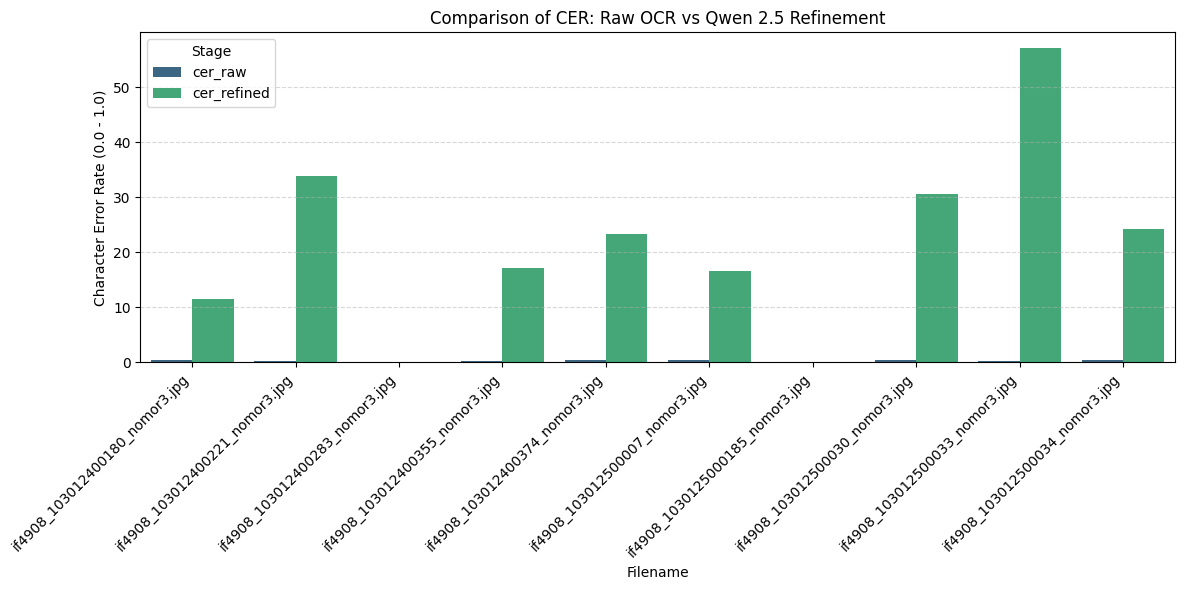

In [9]:
# ===================== VISUALIZE METRICS =====================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if results:
    df = pd.DataFrame(results)
    print(f"Average Time: {df['time'].mean():.4f}s")
    print(f"Average CER (Raw): {df['cer_raw'].mean():.2%}")
    print(f"Average CER (Refined): {df['cer_refined'].mean():.2%}")
    
    try:
        plt.figure(figsize=(12, 6))
        # Melt for seaborn
        df_melted = df.melt(id_vars=['filename'], value_vars=['cer_raw', 'cer_refined'], var_name='Stage', value_name='CER')
        
        sns.barplot(data=df_melted, x='filename', y='CER', hue='Stage', palette='viridis')
        plt.title('Comparison of CER: Raw OCR vs Qwen 2.5 Refinement')
        plt.xlabel('Filename')
        plt.ylabel('Character Error Rate (0.0 - 1.0)')
        # Too many x-labels might clutter, maybe strip?
        if len(df) > 20:
            plt.xticks([]) # Hide x labels if too many
        else:
            plt.xticks(rotation=45, ha='right')
            
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        
        save_path = 'results/cer_comparison.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Graph saved to {save_path}")
        plt.show()
    except Exception as e:
        print(f"Error plotting: {e}")
